<a href="https://colab.research.google.com/github/Ana1890/MRIimages_deeplearning/blob/main/1-weight_model_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadificación de Alzheimer por medio de imágenes MRI utilizando redes neuronales

Dataset provisto por el sitio web de Kaggle: https://www.kaggle.com/tourist55/Alzheimers-dataset-4-class-of-images

Probamos el modelo sin un pre-procesamiento demasiado fino


In [1]:
!pip install progress

  Created wheel for progress: filename=progress-1.5-cp37-none-any.whl size=8088 sha256=2a595f753b938ec75ad47b3f2c37b9b794d45f7ea561278ef22e76108a972455
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress


Accedemos a nuestro drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset')

In [4]:
!ls

loss_plot.png  test  train


In [5]:
!ls test

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [6]:
!ls train

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


# Importamos librerías necesarias

In [7]:
# Generales
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Data
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

# Model
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# from pytorchtools import EarlyStopping

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [8]:
# Fijamos una semilla para asegurar reproducibilidad

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Cargar datos

In [9]:
FOLDER_PATH = '/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset/train'
categories = sorted(os.listdir(FOLDER_PATH))
num_classes = 4

MILD_INDEX = categories.index("MildDemented")
MODERATE_INDEX = categories.index("ModerateDemented")
NON_INDEX = categories.index("NonDemented")
VERYMILD_INDEX = categories.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path = [list() for category in categories]

for index, category in enumerate(categories):
    category_path = os.path.join(FOLDER_PATH, category)

    # Recorrer imágenes
    images = [i for i in os.listdir(category_path)]
    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        images_path[index].append(image_path)

print("Sobre el dataset")
for category_name, images in zip(categories, images_path):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 717
#Imagenes de la clase ModerateDemented: 52
#Imagenes de la clase NonDemented: 2560
#Imagenes de la clase VeryMildDemented: 1792


In [10]:
train_data = list()

for class_index, images_per_class in enumerate(images_path):
  train_data.extend([(img, class_index) for img in images_per_class])

In [11]:
FOLDER_PATH_TEST = '/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset/test'
categories_test = sorted(os.listdir(FOLDER_PATH_TEST))
num_classes = 4

MILD_INDEX_TEST = categories_test.index("MildDemented")
MODERATE_INDEX_TEST = categories_test.index("ModerateDemented")
NON_INDEX_TEST = categories_test.index("NonDemented")
VERYMILD_INDEX_TEST = categories_test.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path_test = [list() for category in categories_test]

for index, category in enumerate(categories_test):
    category_path_test = os.path.join(FOLDER_PATH_TEST, category)

    # Recorrer imágenes
    images_test = [i for i in os.listdir(category_path_test)]
    for image_name in images_test:
        image_path_test = os.path.join(category_path_test, image_name)
        images_path_test[index].append(image_path_test)

print("Sobre el dataset")
for category_name, images in zip(categories_test, images_path_test):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 179
#Imagenes de la clase ModerateDemented: 12
#Imagenes de la clase NonDemented: 640
#Imagenes de la clase VeryMildDemented: 448


In [12]:
test_data = list()

for class_index, images_per_class in enumerate(images_path_test):
  test_data.extend([(img, class_index) for img in images_per_class])

* Las clases están muy desbalanceadas

## Visualización random

In [13]:
def pick_randomly_file(image_list, ammount):
    max_length = len(image_list)
    chosen_images = []
    for _ in range(ammount):
        index = random.randint(0, max_length)
        chosen_images.append(image_list[index])
    
    return chosen_images


sample_images = 5
mild_sample = pick_randomly_file(images_path[MILD_INDEX], sample_images)
moderate_sample = pick_randomly_file(images_path[MODERATE_INDEX], sample_images)
non_sample = pick_randomly_file(images_path[NON_INDEX], sample_images)
Verymild_sample = pick_randomly_file(images_path[VERYMILD_INDEX], sample_images)


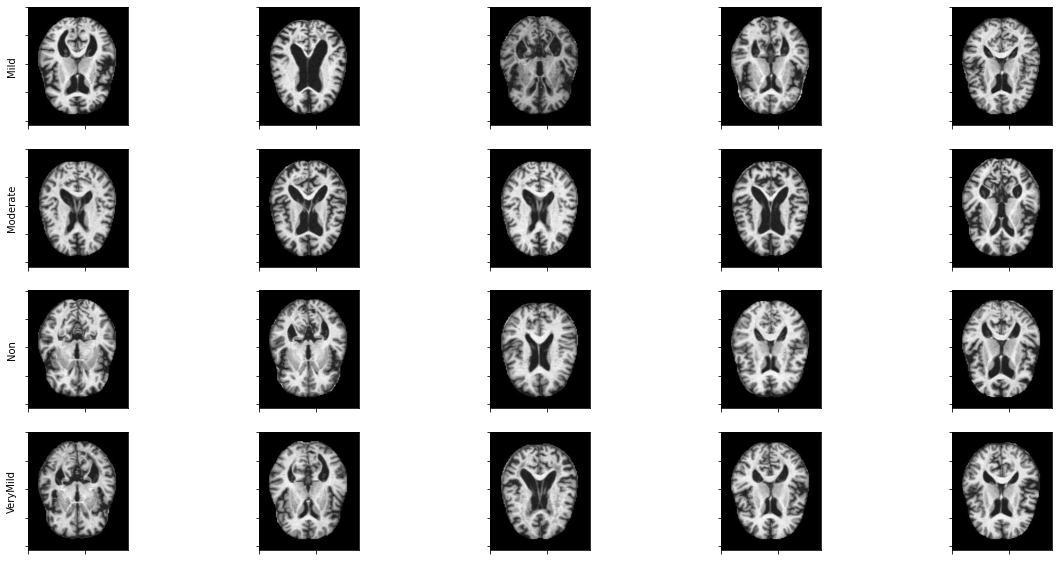

In [14]:
def visualize_sample(image_list, ax, title):
    ax[0].set_ylabel(title)
    for index in range(len(image_list)):        
        ax[index].imshow(cv2.imread(image_list[index]))
        ax[index].set_yticklabels([])
        ax[index].set_xticklabels([])


fx, ax = plt.subplots(num_classes,sample_images, figsize=(20,10))
visualize_sample(mild_sample, ax[0], "Mild")
visualize_sample(moderate_sample, ax[1], "Moderate")
visualize_sample(non_sample, ax[2], "Non")
visualize_sample(Verymild_sample, ax[3], "VeryMild")

plt.show()

In [15]:
image_s = [mild_sample, moderate_sample, non_sample, Verymild_sample]

for s in image_s:
  for l in s:
    print("El tamaño de la imagen ", s.index(l), "de la clase ", categories[image_s.index(s)], "es: ", (cv2.imread(l).size), "y la dimensión es: ", (cv2.imread(l).shape))


El tamaño de la imagen  0 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  1 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  2 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  3 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  4 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  0 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  1 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  2 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  3 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  4 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)


El conjunto de datos se encuentra desbalanceado, tiene imágenes de una dimensión de 208 x 176 x 3 dimensiones. 

# Clase DataSet

Pre-procesamiento planteado: 
* Reshape
* Normalzación
* Mejoras a futuro: data augmentation para las clases minoritarias "Mild demented", "Moderate demented"

In [16]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):

    """MRI dataset."""

    def __init__(self, raw_data, input_size=(224,224)):
        self.raw_data = raw_data
        self.input_size = input_size
        self.images = list()
        self.annotations = list()
        self.count = 0

        for path_to_image, label in self.raw_data:
            image_tensor = self._preprocess(path_to_image)
            target_tensor = torch.tensor(label)

            self.images.append(image_tensor)
            self.annotations.append(target_tensor)

    def _preprocess(self, path_to_image):
        '''
        Función dedicada a convertir nuestra imagen en números.
        Ademas también transforma la imagen en un tensor, que es necesario
        Para poder ser usado en el modelo.
        También se cambia el tamaño de la imagen para que sea uniforme en todas 
        las imágenes.
        '''

        img = cv2.imread(path_to_image)
        img = cv2.resize(img, self.input_size)

        # Aquí normalizamos
        img = img / 255.

        input_tensor = torch.from_numpy(img).reshape(3, self.input_size[0], self.input_size[1]).float()
        
        self.count += 1

        print("Converti a tensor ", self.count)

        return input_tensor

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, index):
        sample = {'input': self.images[index], 'target': self.annotations[index]}
        return sample

# Creamos la red neuronal

In [17]:
add_model = nn.Sequential(
                            nn.Conv2d(2048, 32, kernel_size=(1,1), stride=(1, 1), bias=False),
                            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.Dropout(0.4),
                            nn.Flatten(),
                            nn.Linear(32*7*7,4),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(4,4),
                            nn.LogSoftmax(dim=1)
                          )

In [18]:
# def init_weights(m):

#  if type(m) == nn.Linear:

#    torch.nn.init.xavier_uniform_(m.weight)
#    m.bias.data.fill_(0)

  # elif type(m) == nn.Conv2d:
    # m.weight.data.fill_(0.01)


In [19]:
# add_model.apply(init_weights)

In [20]:
model = models.resnet50(pretrained=True)

new_model = nn.Sequential(
                            model.conv1,
                            model.bn1,
                            model.relu,
                            model.maxpool,
                            model.layer1,
                            model.layer2,
                            model.layer3,
                            *(list(model.layer4.children())[:-1]),
                            add_model

                          )

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

https://www.it-swarm-es.com/es/python/como-eliminar-la-ultima-capa-fc-de-un-modelo-resnet-en-pytorch/807243870/

In [21]:
# Capa 4 sin su última sub capa
# newmodel = torch.nn.Sequential(*(list(model.layer4.children())[:-1]))
# print(newmodel)

# Definimos algunos hiperparámetros

In [22]:

# Hyperparameters
lr = 0.0001              # Learning rate
input_size = (224,224)

# Select the device to use
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Send the model to the device
new_model = new_model.to(device)

# Create dataloader
from torch.utils.data import DataLoader

batch_size = 16

In [23]:
from torchsummary import summary

summary(new_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


https://www.it-swarm-es.com/es/python/como-inicializar-pesos-en-pytorch/837221724/


In [ ]:
dataset = MRIDataset(train_data)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(3)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, worker_init_fn = seed_worker, generator = g)

In [26]:
import torch.optim as optim


# Create an optimizer
optimizer = optim.Adam(new_model.parameters(), lr=lr)


n_samples = len(train_data)
n_classes = len(categories)

w1 = 5
w2 = n_samples/(n_classes*52)
w3 = 2
w4 = n_samples/(n_classes*172)

weight = torch.tensor([w1,w2,w3,w4])

weight = weight.to(device)

# Loss Function
criterion = nn.NLLLoss(weight= weight)

# Entrenamiento

In [27]:
import sys
from progress.bar import Bar

def train_model(new_model, train_data, criterion, optimizer, num_epochs=25):
    new_model.train()
    Bar.check_tty = False
    Bar.file = sys.stdout

    for epoch in range(num_epochs):

        total_loss = 0.0
        processed = 0
        bar = Bar('Training Model', max=len(dataloader))
        for index, data_dict in enumerate(dataloader):
            input_tensor = data_dict["input"]
            gt_tensor = data_dict["target"]

            input_tensor = input_tensor.to(device)
            gt_tensor = gt_tensor.to(device)

            optimizer.zero_grad()
            output = new_model(input_tensor)
            loss = criterion(output, gt_tensor)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            processed += input_tensor.shape[0]
            Bar.suffix = 'Train: [{0}][{1}/{2}]|Tot: {total:} |ETA: {eta:} '.format(epoch+1, processed, len(train_data),total=bar.elapsed_td, eta=bar.eta_td)
            Bar.suffix = Bar.suffix + '| Loss {:.4f} '.format(total_loss / (index + 1))
            bar.next()
        bar.finish()
    return new_model

In [28]:

model = train_model(new_model, train_data, criterion, optimizer, num_epochs = 10)

Training Model |################################| Train: [1][5121/5121]|Tot: 0:00:59 |ETA: 0:00:01 | Loss 1.1901 
Training Model |################################| Train: [2][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 1.0108 
Training Model |################################| Train: [3][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 0.8063 
Training Model |################################| Train: [4][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 0.6139 
Training Model |################################| Train: [5][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 0.5391 
Training Model |################################| Train: [6][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 0.5218 
Training Model |################################| Train: [7][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 0.4942 
Training Model |################################| Train: [8][5121/5121]|Tot: 0:00:58 |ETA: 0:00:01 | Loss 0.5213 
Training Model |################################| Train: [9][5121/5121]|Tot: 0:00:58 |ET

In [45]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [46]:
checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
              }

In [47]:
# Guardé el modelo
save_ckp(checkpoint, False, './checkpoint/current_checkpoint.pt', './best_model/best_model.pt')

# Pre procesamos datos nuevos

In [29]:
def preprocess(path_to_image, label):
    img = cv2.imread(path_to_image)
    img = cv2.resize(img, input_size)    
    img = img / 255.
    input_tensor = torch.from_numpy(img).reshape(1, 3, input_size[0],input_size[1]).float()
    gt_tensor = torch.tensor([label])
    return input_tensor, gt_tensor

In [30]:
def test_model(new_model, test_data):

    y_true = []
    y_pred = []
    new_model = new_model.eval()
    Bar.check_tty = False
    Bar.file = sys.stdout
    bar = Bar('Testing Model', max=len(test_data))

    stats = [0 for _ in categories]
    total_items = [0 for _ in categories]
    for index, input_data in enumerate(test_data):
        img_path, target_class = input_data

        input_tensor, _ = preprocess(img_path, target_class)
        input_tensor = input_tensor.to(device)
        _ = _.to(device)
        output = new_model(input_tensor)
        loss = criterion(output, _)

        prediction = torch.argmax(output).item()
        
        y_pred.append(prediction)
        y_true.append(target_class)


        if target_class == prediction:
            stats[target_class] += 1
        total_items[target_class] += 1
        Bar.suffix = 'Test: [{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(index, len(test_data),total=bar.elapsed_td, eta=bar.eta_td)
        bar.next()
    
    bar.finish()
    for category_name, stat, tot in zip(categories, stats, total_items):
        acc = stat * 1.0 / tot
        print("Accuracy for class {}: {:.4f}".format(category_name, acc))

    print("\nReporte de clasificación: \n", classification_report(y_true, y_pred, target_names = categories))
    print("\nMatriz de confusión: \n")

    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels = categories, yticklabels = categories)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

    

Testing Model |################################| Test: [5120/5121]|Tot: 0:01:08 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.9916
Accuracy for class ModerateDemented: 0.0962
Accuracy for class NonDemented: 0.9867
Accuracy for class VeryMildDemented: 0.9994

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.95      0.99      0.97       717
ModerateDemented       1.00      0.10      0.18        52
     NonDemented       1.00      0.99      0.99      2560
VeryMildDemented       0.97      1.00      0.99      1792

        accuracy                           0.98      5121
       macro avg       0.98      0.77      0.78      5121
    weighted avg       0.98      0.98      0.98      5121


Matriz de confusión: 



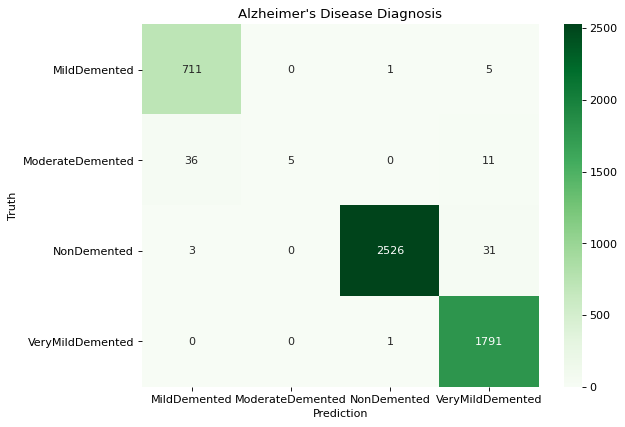

Testing Model |################################| Test: [1278/1279]|Tot: 0:07:26 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.4078
Accuracy for class ModerateDemented: 0.0000
Accuracy for class NonDemented: 0.6531
Accuracy for class VeryMildDemented: 0.6763

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.63      0.41      0.49       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.70      0.65      0.67       640
VeryMildDemented       0.54      0.68      0.60       448

        accuracy                           0.62      1279
       macro avg       0.47      0.43      0.44      1279
    weighted avg       0.63      0.62      0.62      1279


Matriz de confusión: 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


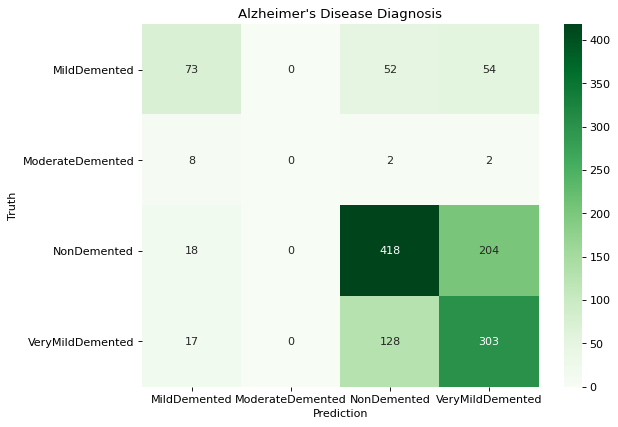

In [31]:
test_model(model, train_data)
test_model(model, test_data)

# Ahora con curvas ROC, AUC y Sylince map

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools
from scipy import interp
import pandas as pd

#Colors
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'

In [74]:
def test_model_curves(new_model, test_data):
    lw = 2
    y_true = []
    y_pred = []
    new_model = new_model.eval()
    Bar.check_tty = False
    Bar.file = sys.stdout
    bar = Bar('Testing Model', max=len(test_data))

    stats = [0 for _ in categories]
    total_items = [0 for _ in categories]
    for index, input_data in enumerate(test_data):
        img_path, target_class = input_data

        input_tensor, _ = preprocess(img_path, target_class)
        input_tensor = input_tensor.to(device)
        _ = _.to(device)
        output = new_model(input_tensor)
        loss = criterion(output, _)

        prediction = torch.argmax(output).item()
        
        y_pred.append(prediction)
        y_true.append(target_class)


        if target_class == prediction:
            stats[target_class] += 1
        total_items[target_class] += 1
        Bar.suffix = 'Test: [{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(index, len(test_data),total=bar.elapsed_td, eta=bar.eta_td)
        bar.next()
    
    bar.finish()
    for category_name, stat, tot in zip(categories, stats, total_items):
        acc = stat * 1.0 / tot
        print("Accuracy for class {}: {:.4f}".format(category_name, acc))

    report = classification_report(y_true, y_pred, target_names = categories )
    
    print("\nReporte de clasificación: \n", report )

    print("\nMatriz de confusión: \n")

    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels = categories, yticklabels = categories)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)
    
    y1 = label_binarize(y_true, classes=[0, 1, 2, 3])
    y2 = label_binarize(y_pred, classes=[0, 1, 2, 3])
    n_classes = y1.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()  
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y1[:, i], y2[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y1.ravel(), y2.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    print("\n")
    plt.figure(figsize = (10,8))
    
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()  


Testing Model |################################| Test: [1278/1279]|Tot: 0:00:17 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.4078
Accuracy for class ModerateDemented: 0.0000
Accuracy for class NonDemented: 0.6531
Accuracy for class VeryMildDemented: 0.6763

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       0.63      0.41      0.49       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.70      0.65      0.67       640
VeryMildDemented       0.54      0.68      0.60       448

        accuracy                           0.62      1279
       macro avg       0.47      0.43      0.44      1279
    weighted avg       0.63      0.62      0.62      1279


Matriz de confusión: 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


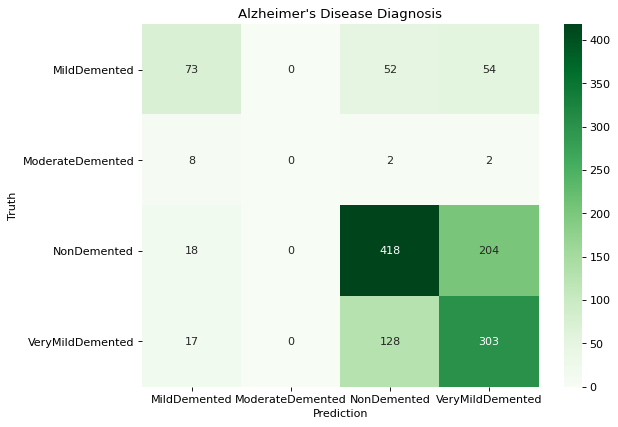

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


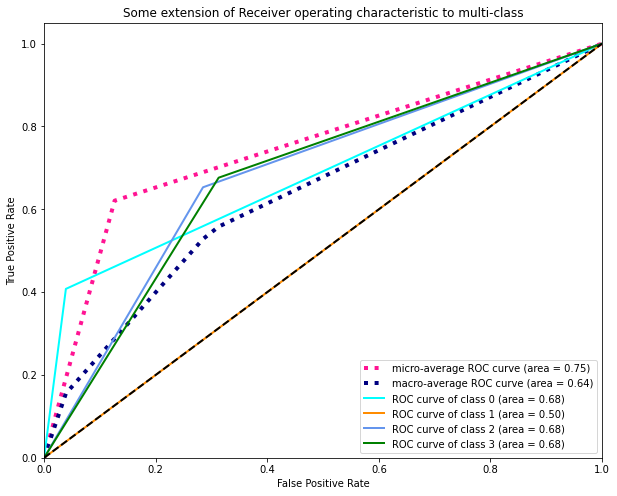

In [75]:
test_model_curves(model, test_data)


Las curvas ROC suelen presentar una tasa de verdaderos positivos en el eje Y y una tasa de falsos positivos en el eje X. Esto significa que la esquina superior izquierda de la gráfica es el punto "ideal": una tasa de falsos positivos de cero y una tasa de verdaderos positivos de uno. Esto no es muy realista, pero significa que un área más grande bajo la curva (AUC) suele ser mejor.

La "inclinación" de las curvas ROC también es importante, ya que es ideal para maximizar la tasa de verdaderos positivos y minimizar la tasa de falsos positivos.

Las curvas ROC se utilizan normalmente en la clasificación binaria para estudiar la salida de un clasificador. Para extender la curva ROC y el área ROC a la clasificación de etiquetas múltiples, es necesario binarizar la salida. Se puede dibujar una curva ROC por etiqueta, pero también se puede dibujar una curva ROC considerando cada elemento de la matriz del indicador de etiqueta como una predicción binaria (micro-average).

Otra medida de evaluación para la clasificación de etiquetas múltiples es el macro-average, que otorga el mismo peso a la clasificación de cada etiqueta.

# Aumentación de datos

https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/ 

https://medium.com/analytics-vidhya/image-data-augmentation-to-balance-dataset-in-classification-tasks-5e25bbd9a228